In [1]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [2]:
data_df = pd.read_csv("./data/input/train.csv")
data_df.head()

,uuid,title,author,abstract,Keywords,label
0,0,Accessible Visual Artworks for Blind and Visua...,"Quero, Luis Cavazos; Bartolome, Jorge Iranzo; ...",Despite the use of tactile graphics and audio ...,accessibility technology; multimodal interacti...,0
1,1,Seizure Detection and Prediction by Parallel M...,"Li, Chenqi; Lammie, Corey; Dong, Xuening; Amir...","During the past two decades, epileptic seizure...",CNN; Seizure Detection; Seizure Prediction; EE...,1
2,2,Fast ScanNet: Fast and Dense Analysis of Multi...,"Lin, Huangjing; Chen, Hao; Graham, Simon; Dou,...",Lymph node metastasis is one of the most impor...,Histopathology image analysis; computational p...,1
3,3,Long-Term Effectiveness of Antiretroviral Ther...,"Huang, Peng; Tan, Jingguang; Ma, Wenzhe; Zheng...",In order to assess the effectiveness of the Ch...,HIV; ART; mortality; observational cohort stud...,0
4,4,Real-Time Facial Affective Computing on Mobile...,"Guo, Yuanyuan; Xia, Yifan; Wang, Jing; Yu, Hui...",Convolutional Neural Networks (CNNs) have beco...,facial affective computing; convolutional neur...,0


In [3]:
data_df.drop(columns=['uuid', 'title', 'author', 'Keywords'], inplace=True, axis=1)
print(data_df.shape)

(6000, 2)


In [4]:
lemmatizer = WordNetLemmatizer()

In [5]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [7]:
import re
import numpy as np

do_remove_punct = True
do_lemmatize = False
do_lowercase = True
do_remove_stop = True
do_remove_nums = True

def custom_tokenize(row):
    text = row['abstract']
    
    # 01 - Punctuations
    if do_remove_punct:
        text = re.sub(r'([^\w\s])', ' ', text)

    # 02 - Lemmatization
    if do_lemmatize:
        tokens_list = nltk.word_tokenize(text)
        text = ' '.join([lemmatizer.lemmatize(t, get_wordnet_pos(t)) for t in tokens_list])

    # 03 - Lowercasing
    if do_lowercase:
        text = text.lower()

    # 04 - Removing stop words (i.e. grammar defining words, not adding value to main topic)
    if do_remove_stop:
        text = ' '.join([t for t in text.split() if t not in stopwords])

    # 05 - Removing numbers
    if do_remove_nums:
        text = re.sub(r'\b[0-9]+\b', ' ', text)

    # Removing redundant spaces
    text = re.sub(r' +', ' ', text)

    row['custom_tokenized'] = text.split()
    return row

data_df['custom_tokenized'] = [list() for _ in range(data_df.shape[0])]
data_df = data_df.apply(custom_tokenize, axis=1)

data_df.head(20)

,abstract,label,custom_tokenized
0,Despite the use of tactile graphics and audio ...,0,"[despite, use, tactile, graphics, audio, guide..."
1,"During the past two decades, epileptic seizure...",1,"[past, two, decades, epileptic, seizure, detec..."
2,Lymph node metastasis is one of the most impor...,1,"[lymph, node, metastasis, one, important, indi..."
3,In order to assess the effectiveness of the Ch...,0,"[order, assess, effectiveness, chinese, govern..."
4,Convolutional Neural Networks (CNNs) have beco...,0,"[convolutional, neural, networks, cnns, become..."
5,Previously we showed the generation of a prote...,1,"[previously, showed, generation, protein, trap..."
6,Facial emotion recognition (FER) is a field of...,0,"[facial, emotion, recognition, fer, field, res..."
7,This paper proposes a machine learning model b...,0,"[paper, proposes, machine, learning, model, ba..."
8,Most current state-of-the-art blind image qual...,0,"[current, state, art, blind, image, quality, a..."
9,Surgical workflow recognition has numerous pot...,1,"[surgical, workflow, recognition, numerous, po..."


# Embeddings
## GloVe

### Installing GloVe Vectors

In [8]:
# %%capture
# !pip install wget

In [9]:
# import wget
# wget.download('http://nlp.stanford.edu/data/glove.6B.zip')

# import shutil
# # Specify the path to the zip file and the target directory
# filename = 'glove.6B.zip'
# extract_dir = 'glove/'
# # Unpack the contents of the zip file into the specified directory
# shutil.unpack_archive(filename, extract_dir)

### Using 50-d

In [10]:
%%time

import numpy as np

glove_embeddings = {}
with open("./glove/glove.6B.300d.txt", encoding='utf-8') as f:
    for line in f:
        try:
            line = line.split()
            glove_embeddings[line[0]] = np.array(line[1:], dtype=np.float32)
        except:
            continue

CPU times: total: 31.4 s
Wall time: 51.4 s


In [11]:
len(glove_embeddings)

400000

In [12]:
glove_embeddings['the'].shape

(300,)

## Data Split

In [13]:
from sklearn.model_selection import train_test_split

X = data_df[['abstract']]
Y = data_df[['label']]

X_train_text, X_test_text, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=42)
del X, Y

In [14]:
# X_train_text

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_tokens = 200 ## Hyperparameter

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_text['abstract'].tolist()+X_test_text['abstract'].tolist())

## Vectorizing data to keep 50 words per sample.
X_train_vect = pad_sequences(tokenizer.texts_to_sequences(X_train_text['abstract'].tolist()), maxlen=max_tokens, padding="post", truncating="post", value=0.)
X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(X_test_text['abstract'].tolist()), maxlen=max_tokens, padding="post", truncating="post", value=0.)

print(X_train_vect[:3])

X_train_vect.shape, X_test_vect.shape

[[   45  3412     8    19   145  3286   503     7   162     2     1    18
      2     1    14   116    54     7  1211    48   104   456   616   298
   1354  3412     8   401   230  3069     5     1   196     4   723    12
     82     6   196   161    45  3412   120     5  1096     6   391    21
     45   403    10   258   661     5     6   159   196    38    61    10
   3175    36   449   196 12391  3412   120     3   176   466  3412   120
   8091   530     4   154     1    24    31  6546     1    45    15   944
      2   608   828  3547     6   440  4937   193   884   109     6  2553
    478     1   255     2     1  4937   193    10  2320   196   161   589
   8628   173  4662    17   945    21    11  1236   318   924   398   319
   2527    36   196   161   150    30     1   319  2527    55  1024     5
      6   151  1487   436    96     1  1102     2     1  2553   478    54
      5  2320     1  4937   193   579     6  1250   187     2    90     5
     26  2448     5   179 20085     3 

((4800, 200), (1200, 200))

In [16]:
X_train_vect[0]

array([   45,  3412,     8,    19,   145,  3286,   503,     7,   162,
           2,     1,    18,     2,     1,    14,   116,    54,     7,
        1211,    48,   104,   456,   616,   298,  1354,  3412,     8,
         401,   230,  3069,     5,     1,   196,     4,   723,    12,
          82,     6,   196,   161,    45,  3412,   120,     5,  1096,
           6,   391,    21,    45,   403,    10,   258,   661,     5,
           6,   159,   196,    38,    61,    10,  3175,    36,   449,
         196, 12391,  3412,   120,     3,   176,   466,  3412,   120,
        8091,   530,     4,   154,     1,    24,    31,  6546,     1,
          45,    15,   944,     2,   608,   828,  3547,     6,   440,
        4937,   193,   884,   109,     6,  2553,   478,     1,   255,
           2,     1,  4937,   193,    10,  2320,   196,   161,   589,
        8628,   173,  4662,    17,   945,    21,    11,  1236,   318,
         924,   398,   319,  2527,    36,   196,   161,   150,    30,
           1,   319,

In [17]:
%%time

embed_len = 300

word_embeddings = np.zeros((len(tokenizer.index_word)+1, embed_len))

for idx, word in tokenizer.index_word.items():
    word_embeddings[idx] = glove_embeddings.get(word, np.zeros(embed_len))

CPU times: total: 31.2 ms
Wall time: 155 ms


In [18]:
target_classes = ['0', '1']

In [19]:
X_train_vect

array([[   45,  3412,     8, ...,   796,     3,   466],
       [    1,   666,    97, ...,  1251,   574,  1237],
       [    7,    19,  1668, ...,   135,     2,    62],
       ...,
       [    1,   570,    14, ...,     0,     0,     0],
       [  475,  9080,     8, ..., 39330,   142,    99],
       [    1,   513,     2, ...,     0,     0,     0]])

# Keras NN

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

model = Sequential([
                    Embedding(input_dim=len(tokenizer.index_word)+1, output_dim=embed_len,
                              input_length=max_tokens, trainable=False, weights=[word_embeddings]),
                    Flatten(),
                    Dense(128, activation="relu"),
                    Dense(64, activation="relu"),
                    Dense(len(target_classes), activation="softmax")
                ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          12748800  
                                                                 
 flatten (Flatten)           (None, 60000)             0         
                                                                 
 dense (Dense)               (None, 128)               7680128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 20437314 (77.96 MB)
Trainable params: 7688514 (29.33 MB)
Non-trainable params: 12748800 (48.63 MB)
_________________________________________________________________


In [21]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [22]:
history = model.fit(X_train_vect, Y_train, batch_size=32, epochs=8, validation_data=(X_test_vect, Y_test))

Epoch 1/8
150/150 [==============================] - 18s 110ms/step - loss: 0.3994 - accuracy: 0.8325 - val_loss: 0.3310 - val_accuracy: 0.8608
Epoch 2/8
150/150 [==============================] - 14s 95ms/step - loss: 0.0410 - accuracy: 0.9894 - val_loss: 0.5242 - val_accuracy: 0.8450
Epoch 3/8
150/150 [==============================] - 13s 90ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.6112 - val_accuracy: 0.8550
Epoch 4/8
150/150 [==============================] - 13s 89ms/step - loss: 2.9626e-04 - accuracy: 1.0000 - val_loss: 0.6554 - val_accuracy: 0.8483
Epoch 5/8
150/150 [==============================] - 14s 95ms/step - loss: 1.2777e-04 - accuracy: 1.0000 - val_loss: 0.6885 - val_accuracy: 0.8558
Epoch 6/8
150/150 [==============================] - 14s 90ms/step - loss: 8.5488e-05 - accuracy: 1.0000 - val_loss: 0.7068 - val_accuracy: 0.8558
Epoch 7/8
150/150 [==============================] - 13s 86ms/step - loss: 6.1285e-05 - accuracy: 1.0000 - val_loss: 0.7264 - val

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Y_preds = model.predict(X_test_vect).argmax(axis=-1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_test, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_test, Y_preds))

38/38 [==============================] - 1s 9ms/step
Test Accuracy : 0.8558333333333333

Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       593
           1       0.88      0.83      0.85       607

    accuracy                           0.86      1200
   macro avg       0.86      0.86      0.86      1200
weighted avg       0.86      0.86      0.86      1200


Confusion Matrix : 
[[526  67]
 [106 501]]


In [27]:
from sklearn.metrics import accuracy_score, f1_score

print('Validation accuracy %s' % accuracy_score(Y_test, Y_preds))
print('Validation F1 score: {}'.format(f1_score(Y_test, Y_preds, average='weighted')))

Validation accuracy 0.8558333333333333
Validation F1 score: 0.8557356781010276


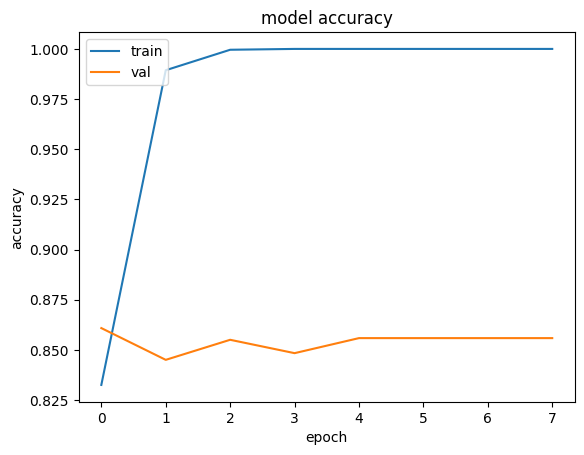

In [25]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()